<a href="https://colab.research.google.com/github/Erocr/fairness/blob/main/UPP26/TD3_audit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TD 3: Audit de modèles



In this TD the aim is to analyse the decision made by a model.
You will use 3 different methods:
- feature importances with LIME
- black box auditing that consider the features by couple
- counter factual examples with dice-ml

## Installation of the environnement

We highly recommend you to follow these steps, it will allow every student to work in an environment as similar as possible to the one used during testing.

### Colab Settings
  The next cell of code are to execute only once per colab environment


#### Python env creation

        ```
        ! python -m pip install numpy fairlearn plotly nbformat ipykernel aif360["inFairness"] aif360['AdversarialDebiasing'] causal-learn BlackBoxAuditing cvxpy dice-ml lime shapkit
        ```
### Local Settings

#### 1. Uv installation


        https://docs.astral.sh/uv/getting-started/installation/


        `curl -LsSf https://astral.sh/uv/install.sh | sh`

        Python version 3.12 installation (highly recommended)
        `uv python install 3.12`


#### 3. Python env creation

        ```
        mkdir TD_bias_mitigation
        cd TD_bias_mitigation
        uv python pin 3.12
        uv init
        uv pip install numpy fairlearn plotly nbformat ipykernel aif360["inFairness"] aif360['AdversarialDebiasing'] causal-learn BlackBoxAuditing cvxpy dice-ml lime shapkit
        ```


In [78]:
! python -m pip install numpy fairlearn plotly nbformat ipykernel aif360["inFairness"] aif360['AdversarialDebiasing'] causal-learn BlackBoxAuditing cvxpy dice-ml lime shapkit


In [79]:
! Rscript /usr/local/lib/python3.12/dist-packages/aif360/data/raw/meps/generate_data.R
! mv h181.csv /usr/local/lib/python3.12/dist-packages/aif360/data/raw/meps/
! mv h192.csv /usr/local/lib/python3.12/dist-packages/aif360/data/raw/meps/


By using this script you acknowledge the responsibility for reading and
abiding by any copyright/usage rules and restrictions as stated on the
MEPS web site (https://meps.ahrq.gov/data_stats/data_use.jsp).

Continue [y/n]? > n
Execution halted
mv: cannot stat 'h181.csv': No such file or directory
mv: cannot stat 'h192.csv': No such file or directory


## Import and load the dataset

In [80]:
# imports
import numpy as np
import pandas as pd
import plotly.express as px
import warnings
import matplotlib.pyplot as plt

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", append=True, category=UserWarning)
# Datasets
from aif360.datasets import MEPSDataset19

# Fairness metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler

MEPSDataset19_data = MEPSDataset19()
(dataset_orig_panel19_train, dataset_orig_panel19_val, dataset_orig_panel19_test) = (
    MEPSDataset19().split([0.5, 0.8], shuffle=True)
)

In [81]:
len(dataset_orig_panel19_train.instance_weights), len(
    dataset_orig_panel19_val.instance_weights
), len(dataset_orig_panel19_test.instance_weights)

(7915, 4749, 3166)

In [82]:
from aif360.sklearn.metrics import *
from sklearn.metrics import  balanced_accuracy_score


# This method takes lists
def get_metrics(
    y_true, # list or np.array of truth values
    y_pred=None,  # list or np.array of predictions
    prot_attr=None, # list or np.array of protected/sensitive attribute values
    priv_group=1, # value taken by the privileged group
    pos_label=1, # value taken by the positive truth/prediction
    sample_weight=None # list or np.array of weights value,
):
    group_metrics = {}
    group_metrics["base_rate_truth"] = base_rate(
        y_true=y_true, pos_label=pos_label, sample_weight=sample_weight
    )
    group_metrics["statistical_parity_difference"] = statistical_parity_difference(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
    )
    group_metrics["disparate_impact_ratio"] = disparate_impact_ratio(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
    )
    if not y_pred is None:
        group_metrics["base_rate_preds"] = base_rate(
        y_true=y_pred, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["equal_opportunity_difference"] = equal_opportunity_difference(
            y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["average_odds_difference"] = average_odds_difference(
            y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
        )
        if len(set(y_pred))>1:
            group_metrics["conditional_demographic_disparity"] = conditional_demographic_disparity(
                y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, pos_label=pos_label, sample_weight=sample_weight
            )
        else:
            group_metrics["conditional_demographic_disparity"] =None
        group_metrics["smoothed_edf"] = smoothed_edf(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["df_bias_amplification"] = df_bias_amplification(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["balanced_accuracy_score"] = balanced_accuracy_score(
        y_true=y_true, y_pred=y_pred, sample_weight=sample_weight
        )
    return group_metrics

## Utilisation de LIME
### Question 1.1 - apprendre une regression logistique qui prédit l'UTILIZATION (comme dans le TD3)

In [83]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

X_train = dataset_orig_panel19_train.features
y_train = dataset_orig_panel19_train.labels[:,0]
X_val = dataset_orig_panel19_val.features
y_val = dataset_orig_panel19_val.labels[:,0]


model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [84]:
dataset_orig_panel19_val.labels

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

### Question 1.2 (optionelle) - Observer l'impact du threshold sur les performances de la regression logistique (balanced accuracy et disparate impact)

In [85]:
pred_proba_df[1]


,1
0,0.204541
1,0.202131
2,0.548991
3,0.279977
4,0.482220
...,...
7910,0.230696
7911,0.324697
7912,0.313729
7913,0.516337


In [86]:
y_train.shape

(7915,)

In [87]:
pred_proba_df = pd.DataFrame(model.predict_proba(X_train))
y_train_serie = pd.Series(y_train)
threshold_list = [0.005,0.05, 0.0545, 0.1, 0.7, 0.9]
for threshold in threshold_list:
    y_predit = pred_proba_df[1].apply(lambda x: 1 if x>threshold else 0)
    print(f"threshold: {threshold}")
    print(disparate_impact_ratio(y_train_serie, y_predit))
    print(balanced_accuracy_score(y_train_serie, y_predit))


threshold: 0.005
0.998610058124842
0.5008445945945946
threshold: 0.05
0.0
0.64929633717499
threshold: 0.0545
0.0
0.6638254109743775
threshold: 0.1
0.0
0.7468277217475364
threshold: 0.7
0.0
0.604860909231009
threshold: 0.9
0.0
0.5236687880130503


### Question 1.3 : apprendre un LimeEncoder (nomer l'objet lime_data) sur le dataset AIF360 de train, puis transformer avec ce LimeEncoder le dataset de train et celui de test en s_train et s_test

In [88]:
from aif360.datasets.lime_encoder import LimeEncoder

In [89]:

lime_data = LimeEncoder().fit(MEPSDataset19_data)

In [90]:
s_train = lime_data.transform(X_train)
s_test = lime_data.transform(X_val)

### Question 1.4 use LimeTabularExplainer to explain the decision made on several instances of the test dataset.


In [91]:
from lime.lime_tabular import LimeTabularExplainer

In [92]:
explainer = LimeTabularExplainer(
        s_train,
        class_names=lime_data.s_class_names,
        feature_names=lime_data.s_feature_names,
        categorical_features=lime_data.s_categorical_features,
        categorical_names=lime_data.s_categorical_names,
        kernel_width=3, verbose=False, discretize_continuous=True)

In [93]:
def s_predict_fn(x):
    return model.predict_proba(lime_data.inverse_transform(x))

In [94]:
def show_explanation(ind):
    exp = explainer.explain_instance(s_test[ind], s_predict_fn, num_features=10)
    print("Actual label: " + str(dataset_orig_panel19_test.labels[ind]))
    exp.as_pyplot_figure()
    plt.show()

Actual label: [0.]


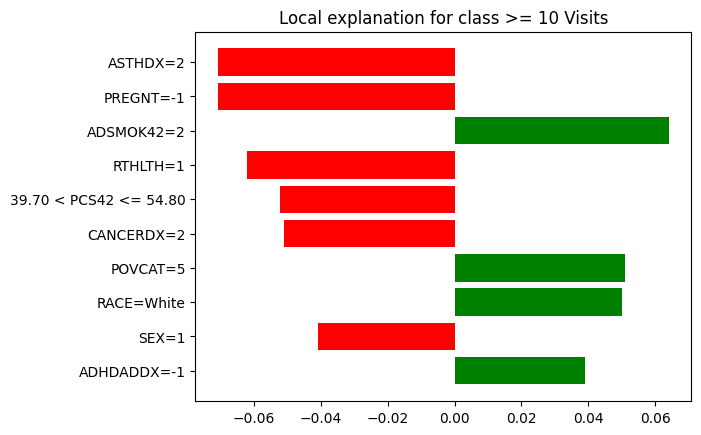

In [95]:
show_explanation(46)

### Question 1.5: Redo the with a regression logistic trained on the Rewieghted dataset

In [96]:
nb_ones = np.sum(y_train)
nb_zeros = len(y_train) - nb_ones
print(f"{nb_ones} / {nb_zeros}")

1403.0 / 6512.0


In [97]:
model_balaced = LogisticRegression(class_weight={0:nb_ones/len(y_train), 1:nb_zeros/len(y_train)})
model_balaced.fit(X_train, y_train)


LogisticRegression(class_weight={0: np.float64(0.17725837018319646),
                                 1: np.float64(0.8227416298168035)})

In [98]:
pred_proba_df = pd.DataFrame(model_balaced.predict_proba(X_train))
y_train_serie = pd.Series(y_train)
threshold_list = [0.005,0.05, 0.0547, 0.1, 0.5, 0.7, 0.9]
for threshold in threshold_list:
    y_predit = pred_proba_df[1].apply(lambda x: 1 if x>threshold else 0)
    print(f"threshold: {threshold}")
    print(disparate_impact_ratio(y_train_serie, y_predit))
    print(balanced_accuracy_score(y_train_serie, y_predit))

threshold: 0.005
1.0
0.5
threshold: 0.05
0.9613343442001516
0.5221956044523757
threshold: 0.0547
0.9564063684609553
0.5251900761968474
threshold: 0.1
0.8907000252716705
0.5603516004665328
threshold: 0.5
0.0
0.7767249912875358
threshold: 0.7
0.0
0.7369528112801456
threshold: 0.9
0.0
0.6244009086355843


## Question2 Utilisation de BlackBoxAuditing

Attention cette fois, nous nous intéressons aux influences indirectes, cette méthode considères les features par couple.

Aussi transformer les attributs catégoriels en "one hot encoding", n'est cette fois pas une bonne approche car ces colonnes seront par construction très liées entre elles.

Nous allons du coup utiliser un ordinal encoding puis uniquement les classifieurs de sklearn compatible avec les attributs catégoriels ( HistGradientBoostingClassifier).

Il faut dans un premier temps transformer le dataset AIF en dataframe et regrouper les colonnes qui ont déjà été one_hot_encodé (tout cela a déja été fait dans le TD3) puis appliqué un ordinal encoding aux colonnes catégorielles

### Question 2.1 preprocesser la donnée

Afin que vous puissiez passer plus de temps à manipuler les explications, nous vous fournissons le code pour bien formatter le dataframe
vous pouvez passer à la 2.2

In [99]:
from sklearn import preprocessing


def get_df(MepsDataset):
    data = MepsDataset.convert_to_dataframe()
    # data_train est un tuple, avec le data_frame et un dictionnaire avec toutes les infos (poids, attributs sensibles etc)
    df = data[0]
    df["WEIGHT"] = data[1]["instance_weights"]
    # Get categorical column from one hot encoding (specitic to MEPSdataset)
    # Here we create a dictionnary that links each categorical column name
    # to the list of corresponding one hot encoded columns
    categorical_columns_dic = {}
    for col in df.columns:
        col_split = col.split("=")
        if len(col_split) > 1:
            cat_col = col_split[0]
            if not (cat_col in categorical_columns_dic.keys()):
                categorical_columns_dic[cat_col] = []
            categorical_columns_dic[cat_col].append(col)
    categorical_features = categorical_columns_dic.keys()
    print(categorical_features)

    def categorical_transform(df, onehotencoded, cat_col):
        if len(onehotencoded) > 1:
            return df[onehotencoded].apply(
                lambda x: onehotencoded[np.argmax(x)][len(cat_col) + 1 :], axis=1
            )
        else:
            return df[onehotencoded]


    # Reverse the categorical one hot encoded
    for cat_col, onehotencoded in categorical_columns_dic.items():
        df[cat_col] = categorical_transform(df, onehotencoded, cat_col)
        df.drop(columns=onehotencoded, inplace=True)

    encoders = {cat_col:preprocessing.LabelEncoder() for cat_col in categorical_features}

    for cat_col in categorical_features:
        df[cat_col] = encoders[cat_col].fit_transform(df[cat_col])
        print(cat_col)
        for idx in sorted(df[cat_col].unique()):
            print(idx, encoders[cat_col].inverse_transform([idx]))
    return df, encoders


df, encoders = get_df(MEPSDataset19_data)

dict_keys(['REGION', 'SEX', 'MARRY', 'FTSTU', 'ACTDTY', 'HONRDC', 'RTHLTH', 'MNHLTH', 'HIBPDX', 'CHDDX', 'ANGIDX', 'MIDX', 'OHRTDX', 'STRKDX', 'EMPHDX', 'CHBRON', 'CHOLDX', 'CANCERDX', 'DIABDX', 'JTPAIN', 'ARTHDX', 'ARTHTYPE', 'ASTHDX', 'ADHDADDX', 'PREGNT', 'WLKLIM', 'ACTLIM', 'SOCLIM', 'COGLIM', 'DFHEAR42', 'DFSEE42', 'ADSMOK42', 'PHQ242', 'EMPST', 'POVCAT', 'INSCOV'])
REGION
0 ['1']
1 ['2']
2 ['3']
3 ['4']
SEX
0 ['1']
1 ['2']
MARRY
0 ['1']
1 ['10']
2 ['2']
3 ['3']
4 ['4']
5 ['5']
6 ['6']
7 ['7']
8 ['8']
9 ['9']
FTSTU
0 ['-1']
1 ['1']
2 ['2']
3 ['3']
ACTDTY
0 ['1']
1 ['2']
2 ['3']
3 ['4']
HONRDC
0 ['1']
1 ['2']
2 ['3']
3 ['4']
RTHLTH
0 ['-1']
1 ['1']
2 ['2']
3 ['3']
4 ['4']
5 ['5']
MNHLTH
0 ['-1']
1 ['1']
2 ['2']
3 ['3']
4 ['4']
5 ['5']
HIBPDX
0 ['-1']
1 ['1']
2 ['2']
CHDDX
0 ['-1']
1 ['1']
2 ['2']
ANGIDX
0 ['-1']
1 ['1']
2 ['2']
MIDX
0 ['-1']
1 ['1']
2 ['2']
OHRTDX
0 ['-1']
1 ['1']
2 ['2']
STRKDX
0 ['-1']
1 ['1']
2 ['2']
EMPHDX
0 ['-1']
1 ['1']
2 ['2']
CHBRON
0 ['-1']
1 ['1']
2 ['2'

In [100]:
df

,AGE,RACE,PCS42,MCS42,K6SUM42,UTILIZATION,WEIGHT,REGION,SEX,MARRY,...,ACTLIM,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV
0,53.0,1.0,25.93,58.47,3.0,1.0,21854.981705,1,0,5,...,1,2,2,2,2,2,1,4,0,1
1,56.0,1.0,20.42,26.57,17.0,1.0,18169.604822,1,1,3,...,1,2,2,2,2,2,7,4,2,1
3,23.0,1.0,53.12,50.33,7.0,0.0,17191.832515,1,1,5,...,2,2,2,2,2,2,1,1,1,1
4,3.0,1.0,-1.00,-1.00,-1.0,0.0,20261.485463,1,0,6,...,0,2,0,2,2,0,0,0,1,1
5,27.0,0.0,-1.00,-1.00,-1.0,0.0,0.000000,2,0,0,...,2,2,2,2,2,0,0,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16573,25.0,0.0,56.71,62.39,0.0,0.0,4111.315754,2,0,0,...,2,2,2,2,2,2,1,1,0,0
16574,25.0,0.0,56.71,62.39,0.0,0.0,5415.228173,2,1,0,...,2,2,2,2,2,2,1,4,0,0
16575,2.0,1.0,-1.00,-1.00,-1.0,0.0,3896.116219,2,1,6,...,0,2,0,2,2,0,0,0,0,1
16576,54.0,0.0,43.97,42.45,24.0,0.0,4883.851005,0,1,3,...,2,2,2,2,2,2,1,1,2,1


### Question 2.2  Separation train/test du dataframe transformé pour BlackBoxAudit

In [101]:
len(MEPSDataset19_data.labels)

15830

In [116]:
train_size = int(len(df)*0.6)

X_train = df.iloc[:train_size]
y_train = MEPSDataset19_data.labels[:train_size,0]
X_val = df.iloc[train_size:]
y_val = MEPSDataset19_data.labels[train_size:,0]


### Question 2.3: Apprentissage d'un modèle HistGradientBoostingClassifier

In [121]:
from sklearn.ensemble import HistGradientBoostingClassifier

clf = HistGradientBoostingClassifier()
clf.fit(X_train, y_train)

HistGradientBoostingClassifier()

### Question 2.4 utiliser la librairie BlackBoxAuditing pour "auditer" le modèle par l'analyse des influences indirectes de l'age (le calcul prend du temps mais n'hesitez pas à faires d'autres attributs)

Le code est de nouveau fournit, vous avez juste à adapter avec vos notations

Voici la documentaiton de la librairie utilisée
https://github.com/algofairness/BlackBoxAuditing/tree/master

In [122]:
import pickle

# Save your data (name X_test, y_test, X_train, y_train here) and model (named clf here) on disk

data_test = X_val.copy(deep=True)
data_test["Y"] = y_val

data_test.to_csv("TD5_test_data.csv",
          index=False)

data_train = X_train.copy(deep=True)
data_train["Y"] = y_train

data_train.to_csv("TD5_train_data.csv",
          index=False)

with open( 'TD5_clf.pickle', 'wb' ) as f:
    pickle.dump(clf, f )

In [123]:
from BlackBoxAuditing.data import load_from_file
from BlackBoxAuditing.model_factories.AbstractModelFactory import AbstractModelFactory
from BlackBoxAuditing.model_factories.AbstractModelVisitor import AbstractModelVisitor

import BlackBoxAuditing as BBA


(_, train_BBA, _, _, _, _) = load_from_file("TD5_train_data.csv",
                      correct_types = [int if col_type=="int" else float for col_type in  data_train.dtypes],
                                response_header = 'Y',
                               train_percentage = 1.0)
(headers, _, test_BBA, response_header, features_to_ignore, correct_types) = load_from_file("TD5_test_data.csv",
                      correct_types = [int if col_type=="int" else float for col_type in  data_test.dtypes],
                                response_header = 'Y',
                               train_percentage = 0.0)
BBA_data = (headers, train_BBA, test_BBA, response_header, features_to_ignore, correct_types)

In [124]:
class HirePredictorBuilder(AbstractModelFactory):
    def __init__(self, *args, **kwargs):
        AbstractModelFactory.__init__(self, *args, **kwargs)
        self.verbose_factory_name = "HirePredictor"
    def build(self, train_set):
        return HirePredictor()

class HirePredictor(AbstractModelVisitor):
    def __init__(self):
        with open( 'TD5_clf.pickle', 'rb' ) as f:
            self.clf = pickle.load(f)

    def test(self, test_set, test_name=""):
        return [[v[-1], self.clf.predict(np.expand_dims(np.array(v[:-1]), axis = 0))] for v in test_set]


In [125]:
features_to_audit = [
    "AGE",
    "SEX",
    "RACE",
    "REGION"
    ]

In [126]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

auditor = BBA.Auditor()
auditor.ModelFactory = HirePredictorBuilder
auditor(BBA_data, output_dir = "audit-output", features_to_audit=features_to_audit)

Training initial model. (11:01:06)
Calculating original model statistics on test data:
	Training Set:
		Conf-Matrix: {1.0: {1.0: 1624}, 0.0: {0.0: 7874}}
		accuracy: 1.0
		BCR: 1.0
	Testing Set:
		Conf-Matrix {0.0: {0.0: 5238}, 1.0: {1.0: 1094}}
		accuracy: 1.0
		BCR: 1.0
Auditing: 'AGE' (1/4). (11:01:20)
Auditing: 'SEX' (2/4). (11:02:38)
Auditing: 'RACE' (3/4). (11:04:01)
Auditing: 'REGION' (4/4). (11:05:29)
Audit file dump set to False: Only mininal audit files have been saved.
Audit files dumped to: audit-output.

Ranking audit files by accuracy. (11:06:43)
	[('AGE', 0.0), ('SEX', 0.0), ('RACE', 0.0), ('REGION', 0.0)] (11:06:43)
Ranking audit files by BCR. (11:06:43)
	[('AGE', 0.0), ('SEX', 0.0), ('RACE', 0.0), ('REGION', 0.0)] (11:06:43)
Audit Start Time: 2026-01-30 11:01:06.191067
Audit End Time: 2026-01-30 11:06:43.172733
Retrained Per Repair: False
Model Factory ID: 1769770866.1912313
Model Type: HirePredictor
Non-standard Model Options: {}
Train Size: 9498
Test Size: 6332
Non-s

### Question 2.5: If you are curious redo the auditing of a model with bias mitigation approach (for example Reweighing)

In [127]:
print("I'm not curious !")

I'm not curious !


## Question 3: Generer des exemples contrefactuels en utilisant dice-ml

Voici la documentation de la librairie utilisée
https://github.com/interpretml/DiCE?tab=readme-ov-file


In [128]:
import dice_ml
from dice_ml.utils import helpers

In [129]:
# provide the trained ML model to DiCE's model object
# use the HistGradientBoostingClassifier from the BlackBoxAuditiing
backend = 'sklearn'
m = dice_ml.Model(model=clf, backend=backend)

### Question 3.1 : Create a list with all continuous features

In [132]:
list_continuous = ["PCS42", "MCS42", "WEIGHT"]

### Question 3.2 ceate a dice_ml Data with the dataframe.

In [137]:
X_train["Y"] = y_train
X_val["Y"] = y_val

In [138]:
d = dice_ml.Data(dataframe=X_train,
                 continuous_features=list_continuous,
                 outcome_name="Y")

### Question 3.3  use dice to create counterfactual example using the 'random' method

In [ ]:
dice = dice_ml.Dice(d, m)
query_instance = X_train.drop(columns="Y")
dice.generate_counterfactuals(query_instance, 1)

 13%|█▎        | 1254/9498 [04:35<20:23,  6.74it/s]

### Question 3.4 Redo the counterfactuals creation using only data statistics not the data itself

In [ ]:
print("TODO")

### Question 3.5: If you are curious redo the counter factual example creation with a model with bias mitigation approach (for example Reweighing)

In [ ]:
print("Me not cursus universitaire 🫦")